In [1]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


## Klasifikasi

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
np.random.seed(123)
tf.random.set_seed(123)
tf.keras.utils.set_random_seed(123)

In [3]:
# Parameter
CLASSES     = ['Air', 'Lahan Terbangun', 'Vegetasi']
N_CLASSES   = len(CLASSES)
PALETTE     = ['#F08080', '#D2B48C', '#87CEFA']

### Preprocessing

In [5]:
df = pd.read_csv(PATH + 'data.csv')
df

,B4,B8,NDVI,label,tahun
0,639.000000,456.000000,-0.167123,air,2015
1,684.000000,494.000000,-0.161290,air,2015
2,789.000000,599.000000,-0.136888,air,2015
3,1280.000000,1061.000000,-0.093550,air,2015
4,1279.000000,1061.000000,-0.093162,air,2015
...,...,...,...,...,...
87682,2308.500000,3638.500000,0.223642,vegetasi,2023
87683,2170.083333,3408.333333,0.221972,vegetasi,2023
87684,2262.666667,3647.416667,0.234303,vegetasi,2023
87685,2257.000000,3505.000000,0.216591,vegetasi,2023


In [6]:
# Split data
X = df[['B4', 'B8']] # menggunakan B4 dan B8
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Label encoder
le = LabelEncoder()
le.fit(y_train)

y_train = le.fit_transform(y_train)
y_test  = le.fit_transform(y_test)

In [8]:
# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(np.array(X_train))
test_input = reshape_input(np.array(X_test))

# Also make label data to categorical
train_output = to_categorical(y_train, N_CLASSES + 1)
test_output = to_categorical(y_test, N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (70149, 2, 1)
Test features: (17538, 2, 1)
Train label: (70149, 4)
Test label: (17538, 4)


In [9]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 128
drop = 0.1
kernel = 1
pool = 1

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 3, kernel, activation='relu'),
  Conv1D(neuron * 3, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 3, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 128)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            16512     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 128)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 128)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 256)            33024     
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 256)            65792     
                                                        

In [10]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
model_path = PATH + 'cnn_model.h5'
stop = [ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5)]

# Fit the model
history = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=64,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
1095/1097 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.7784
Epoch 1: val_accuracy improved from -inf to 0.86601, saving model to /content/drive/MyDrive/cnn_model.h5
1097/1097 [==============================] - 57s 47ms/step - loss: 0.8736 - accuracy: 0.7784 - val_loss: 0.4207 - val_accuracy: 0.8660
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1096/1097 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8747
Epoch 2: val_accuracy did not improve from 0.86601
1097/1097 [==============================] - 45s 41ms/step - loss: 0.3178 - accuracy: 0.8747 - val_loss: 0.2979 - val_accuracy: 0.8517
Epoch 3/100
1096/1097 [============================>.] - ETA: 0s - loss: 0.2432 - accuracy: 0.9024
Epoch 3: val_accuracy improved from 0.86601 to 0.90683, saving model to /content/drive/MyDrive/cnn_model.h5
1097/1097 [==============================] - 47s 43ms/step - loss: 0.2432 - accuracy: 0.9024 - val_loss: 0.1898 - val_accuracy: 0.9068
Epoch 4/100
1096/1097 [============================>.] - ETA: 0s - loss: 0.1914 - accuracy: 0.9249
Epoch 4: val_accuracy improved from 0.90683 to 0.94777, saving model to /content/drive/MyDrive/cnn_model.h5
1097/1097 [==============================] - 44s 40ms/step - loss: 0.1914 - accuracy: 0.9249 - val_loss: 0.1196 - val_accuracy: 0.9478
Epoch 5/100
1095/1097 [====================

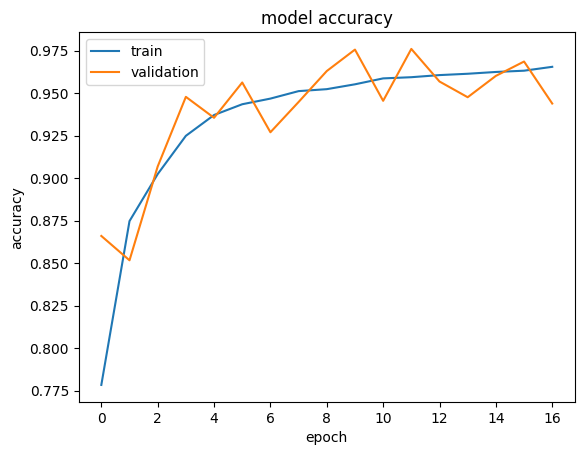

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

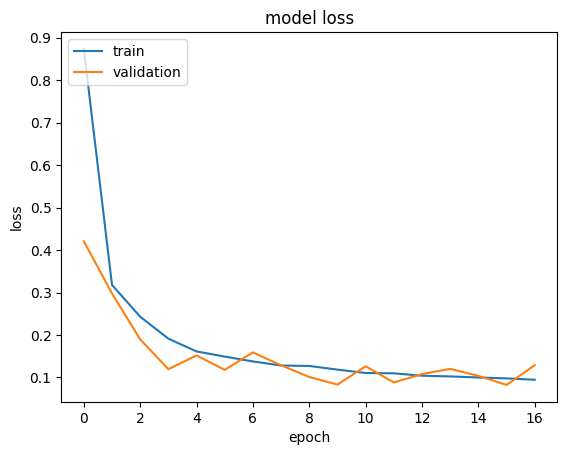

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
n_model = load_model(model_path)

# Predict test data
prediction = np.argmax(n_model.predict(test_input), 1).flatten()
label      = np.argmax(test_output, 1).flatten()

549/549 [==============================] - 3s 5ms/step


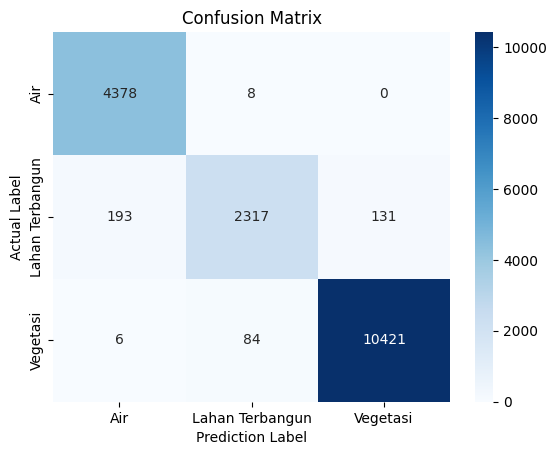

In [14]:
cm           = confusion_matrix(label, prediction)
df_confusion = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

In [15]:
accuracy_  = round(accuracy_score(label, prediction)*100, 2)
precision_ = round(precision_score(label, prediction, average='weighted')*100, 2)
recall_    = round(recall_score(label, prediction, average='weighted')*100, 2)
f1_score_  = round(f1_score(label, prediction, average='weighted')*100, 2)

print('Accuracy  : ', accuracy_)
print('Precision : ', precision_)
print('Recall    : ', recall_)
print('F1-score  : ', f1_score_)

Accuracy  :  97.59
Precision :  97.59
Recall    :  97.59
F1-score  :  97.55
